In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, LabelEncoder

data = pd.read_csv(r'C:\Users\Kerry\spend_analysis_dataset.csv')
print(data.shape)
data.head()

(500, 9)


,TransactionID,ItemName,Category,Quantity,UnitPrice,TotalCost,PurchaseDate,Supplier,Buyer
0,TXN001,Desk Chair,Furniture,10,113.15,1131.50,2024-04-19,TechMart Inc.,Kelly Joseph
1,TXN002,Stapler,Office Supplies,16,12.62,201.92,2024-07-06,CloudSoft Corp.,Kelly Joseph
2,TXN003,Annual Software License,Software,1,5649.34,5649.34,2024-09-10,TechMart Inc.,Kelly Joseph
3,TXN004,Notepad,Stationery,13,2.92,37.96,2024-01-21,FurniWorks Ltd.,Luis Holland
4,TXN005,Notepad,Stationery,19,1.39,26.41,2024-02-03,TechMart Inc.,Cynthia Jenkins


In [37]:
data.isnull().sum()

TransactionID    0
ItemName         0
Category         0
Quantity         0
UnitPrice        0
TotalCost        0
PurchaseDate     0
Supplier         0
Buyer            0
dtype: int64

In [38]:
data.duplicated().sum()

0

In [39]:
data.describe

<bound method NDFrame.describe of     TransactionID                 ItemName         Category  Quantity  \
0          TXN001               Desk Chair        Furniture        10   
1          TXN002                  Stapler  Office Supplies        16   
2          TXN003  Annual Software License         Software         1   
3          TXN004                  Notepad       Stationery        13   
4          TXN005                  Notepad       Stationery        19   
..            ...                      ...              ...       ...   
495        TXN496               Whiteboard        Furniture        19   
496        TXN497                   Laptop      Electronics         5   
497        TXN498                  Notepad       Stationery         3   
498        TXN499               Whiteboard        Furniture        17   
499        TXN500                  Stapler  Office Supplies         4   

     UnitPrice  TotalCost PurchaseDate            Supplier            Buyer  
0       113

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   TransactionID  500 non-null    object 
 1   ItemName       500 non-null    object 
 2   Category       500 non-null    object 
 3   Quantity       500 non-null    int64  
 4   UnitPrice      500 non-null    float64
 5   TotalCost      500 non-null    float64
 6   PurchaseDate   500 non-null    object 
 7   Supplier       500 non-null    object 
 8   Buyer          500 non-null    object 
dtypes: float64(2), int64(1), object(6)
memory usage: 35.3+ KB


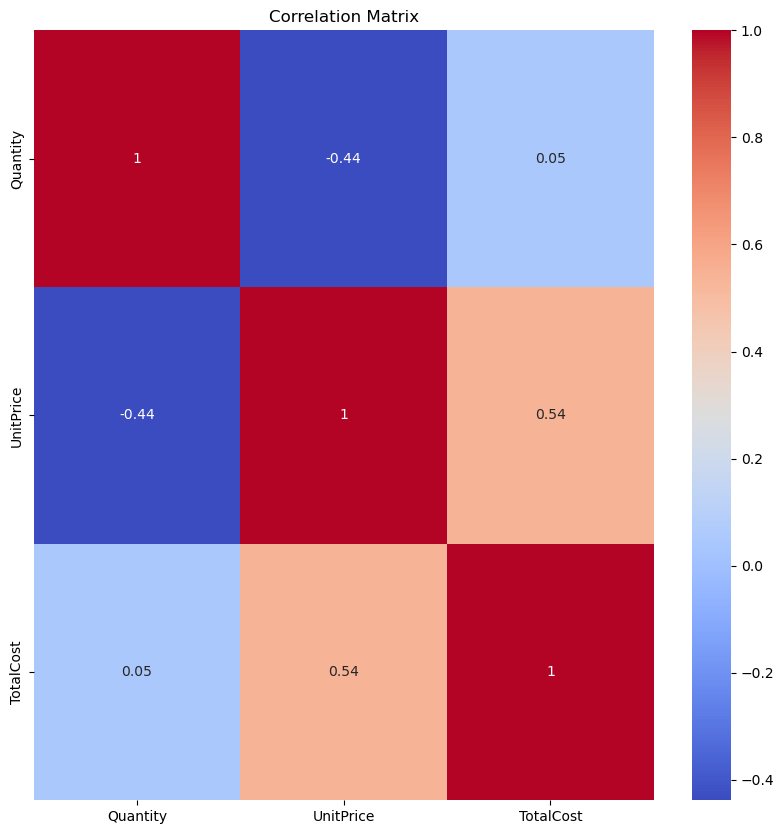

In [41]:
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

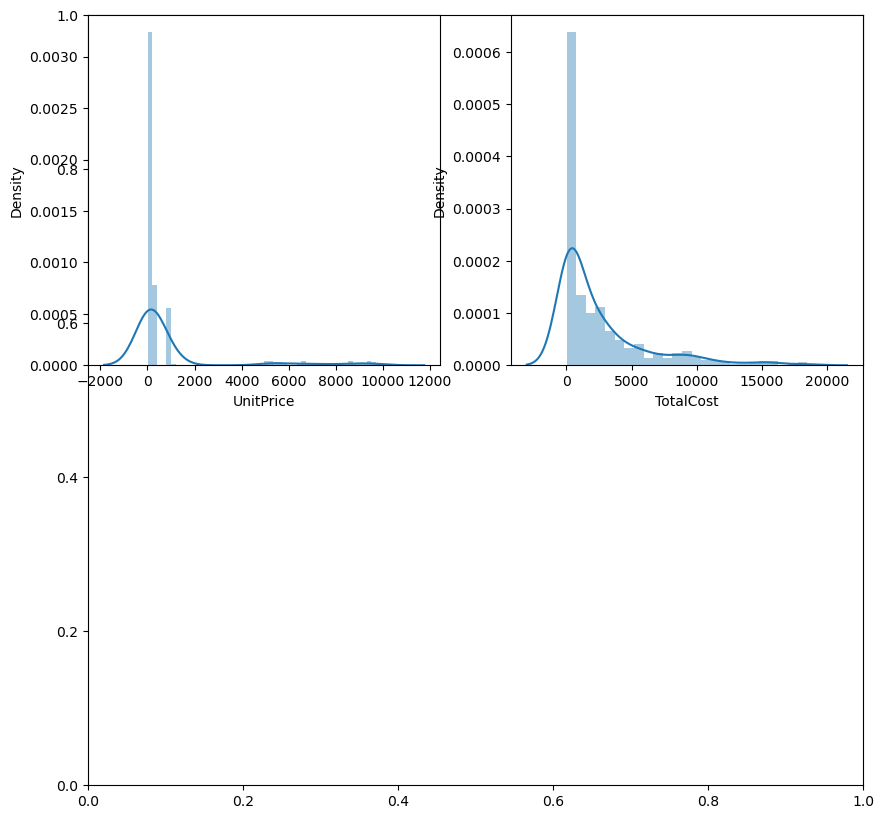

In [42]:
features = ['UnitPrice', 'TotalCost']
plt.subplots(figsize=(10,10))
for i,col in enumerate(features):
    plt.subplot(2,2,i+1)
    sns.distplot(data[col])
plt.show()

In [43]:
df_encoded = data.copy()
label_encoders = {}

# Encode the target variable
le_target = LabelEncoder()
df_encoded['Category'] = le_target.fit_transform(df_encoded['Category'])

# Encode categorical features
categorical_cols = ['ItemName', 'Buyer']
for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

# Features and targets
X = df_encoded.drop(columns=['TransactionID', 'Quantity', 'UnitPrice', 'TotalCost', 'PurchaseDate', 'Buyer', 'Supplier'])
y = df_encoded['Category']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Grid searcg for best svm polynomial parameters
param_grid = {
    'C': [1],
    'degree': [2],
    'gamma': ['scale'],
    'kernel': ['poly']
}

grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model from grid search
svm_model = grid_search.best_estimator_

# Predict and evaluate
y_pred = svm_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(
    y_test,
    y_pred,
    labels=np.unique(y_pred), 
    target_names=le_target.inverse_transform(np.unique(y_pred)))

# Results
print("Best parameters:", grid_search.best_params_)
print("\nConfusion matrix:\n", conf_matrix)
print("\nClassification report:\n", class_report)


Best parameters: {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}

Confusion matrix:
 [[13  0  0  0  0  0]
 [ 0 28  0  0  0  0]
 [ 0  0 22  0  0  0]
 [ 0  0  0 10  0  0]
 [ 0  0  0  0  8  0]
 [ 0  0  0  0  0 19]]

Classification report:
                  precision    recall  f1-score   support

    Accessories       1.00      1.00      1.00        13
    Electronics       1.00      1.00      1.00        28
      Furniture       1.00      1.00      1.00        22
Office Supplies       1.00      1.00      1.00        10
       Software       1.00      1.00      1.00         8
     Stationery       1.00      1.00      1.00        19

       accuracy                           1.00       100
      macro avg       1.00      1.00      1.00       100
   weighted avg       1.00      1.00      1.00       100



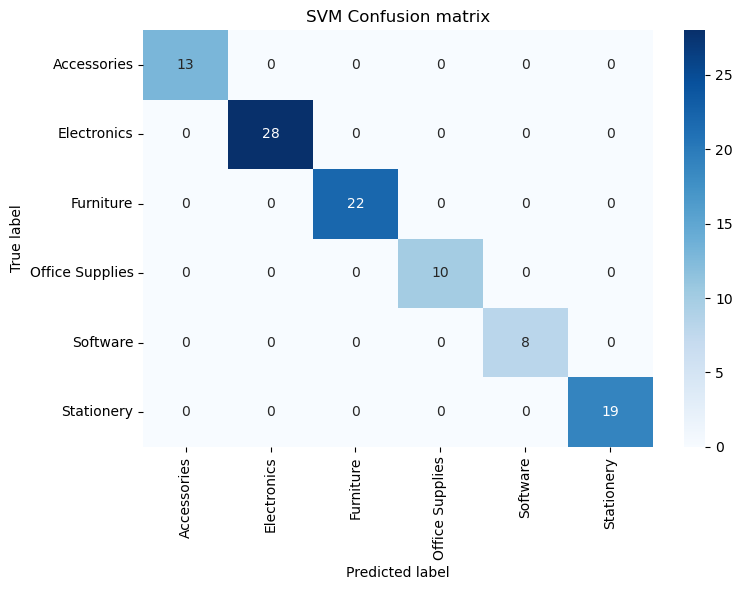

In [44]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_target.classes_,
            yticklabels=le_target.classes_)
plt.title("SVM Confusion matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()